In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import skimage.io as io
from skimage.feature import hog
from skimage.transform import resize

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Load data

In [2]:
# set random seed for reproducable result
RANDOM_SEED = 1612348362
np.random.seed(seed=RANDOM_SEED)

In [3]:
DATA_DIR = './dataset/dataset/'
IMG_DIR = os.path.join(DATA_DIR, 'logos')

In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'origin_train.csv'))
val_df = pd.read_csv(os.path.join(DATA_DIR, 'origin_val.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'origin_test.csv'))

Xem thông tin tập huấn luyện

In [5]:
train_df.head()

,File name,Company
0,logo_1375.jpg,vinamilk
1,logo_965.png,viettel
2,logo_560.jpg,tgdd
3,logo_1070.jpg,vinamilk
4,logo_1145.png,vinamilk


Đổi tên cột từ `['File name', 'Company']` thành `[filename, company]` để tiện truy xuất bằng `row.tên_cột` sẽ được sử dụng bên dưới

In [6]:
train_df.columns = ['filename', 'company']
val_df.columns = ['filename', 'company']
test_df.columns = ['filename', 'company']

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 2 columns):
filename    189 non-null object
company     189 non-null object
dtypes: object(2)
memory usage: 3.1+ KB


In [8]:
train_df.describe()

,filename,company
count,189,189
unique,189,5
top,logo_800.png,vinamilk
freq,1,61


Nối đường dẫn đến tên hình file ảnh: Ở đây khai báo một lớp `LoadImage` kế thừa từ `BaseEstimator` và `TransformerMixin` để có các phương thức `fit`, `transform` và để visualize sample bên dưới. Sau đó có thể tái sử dụng lớp này khi đưa vào pipeline.

In [9]:
class LoadImage(BaseEstimator, TransformerMixin):
    def __init__(self, img_dir=IMG_DIR):
        self.img_dir = img_dir
    
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_df, y=None):
        img_series = X_df['filename'].apply(self.load_image)
        return img_series
    
    def load_image(self, filename: str):
        img = io.imread(os.path.join(self.img_dir, filename))
        return img

Visualize một số mẫu trong tập huấn luyện

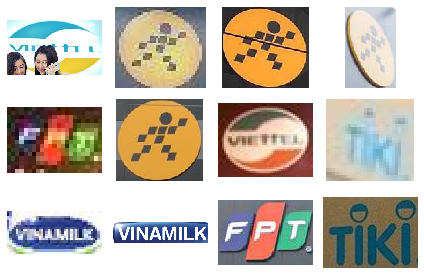

In [10]:
def visualize_some_samples(df, num_samples=20):
    num_samples_per_row = 4
    assert (num_samples % num_samples_per_row == 0)
    num_samples = min(len(df), num_samples) # in case data frame has less sample than num_samples
    sample_idxs = np.random.choice(len(df), num_samples, replace=False)
    
    figure, axes = plt.subplots(num_samples // num_samples_per_row, num_samples_per_row)
    axes = axes.ravel()
    
    loader = LoadImage(IMG_DIR)
    img_sr = loader.fit_transform(df)
    for i, img in enumerate(img_sr.iloc[sample_idxs]):
        axes[i].imshow(img)
        axes[i].axis('off')
        
    figure.tight_layout()
    plt.show()

visualize_some_samples(train_df, num_samples=12)

# Đặc trưng HOG

Đặc trưng HOG (Histogram Of Gradient) được sử dụng khá phổ biến trong giai đoạn đầu (trước khi xuất hiện DeepLearning) trong bài toán phát hiện đối tượng (Object Detection) và nhận dạng đối tượng (Object Recognition). Có thể xem qua bài báo gốc tại [đây](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf) với gần 30000 lượt citing từ năm 2005.

Ngoài ra, đặc trưng HOG không yêu cầu tính toán quá phức tạp và về mặt trực quan, đặc trưng HOG dễ *thông dịch* hơn. Tức là khi nhìn vào đặc trưng sau khi rút trích, ta có thể mường tượng được tại sao HOG được sử dụng phổ biến như vậy.

Và trên hết, thuật toán đã được cài đặt sẵn trong thư viện `sklearn-image` và nhóm chỉ gọi hàm để sử dụng mà không phải cài đặt lại :p

Khai báo lớp `HOGFeatureExtractor` kế thừa từ `BaseEstimator` và `TransformerMixin` để có các phương thức `fit`, `transform`. Đặc trưng bao gồm nhiều siêu tham số, như số pixel trong một cell và số cell trong 1 block, số orientation ... (chi tiết các tham số bạn có thể xem tại [đây](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.hog)).

Tuy nhiên để HOG hoạt động đối với ảnh đa dạng kích thước cần có bước resize ảnh (thì số chiều của đặc trưng sẽ như nhau), nhưng resize ảnh sẽ làm biến dạng nội dung bên trong, dẫn đến ảnh hưởng đến kết quả nhận dạng, do đó nhóm chọn kích thước ảnh resize gồm `HOG_ROWS` và `HOG_COLS` là 2 siêu tham số chính của mô hình.

Về siêu tham số của bản thân thuật toán nhóm chọn siêu tham số `orientations` là số bins của histogram, càng nhiều thì sẽ độ phức tạp tính toán càng cao nhưng càng chính xác (hi vọng là vậy), còn các siêu tham số khác nhóm để mặc định của thư viện

In [11]:
class HOGFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, hog_rows=64, hog_cols=128, orientations=9):
        self.hog_rows = hog_rows
        self.hog_cols = hog_cols
        self.orientations = orientations
        
    def fit(self, X_df, y=None):
        return self
    
    def transform(self, X_sr, y=None):
        features = X_sr.apply(self.extract)
        return np.array(features.tolist())
    
    def extract(self, img: np.ndarray):
        img = resize(img, (self.hog_rows, self.hog_cols), mode='constant')
        features = hog(image=img, orientations=self.orientations)
        return features

Visualize một số ảnh đặc trưng HOG với `HOG_ROWS=64` và `HOG_COLS=128`

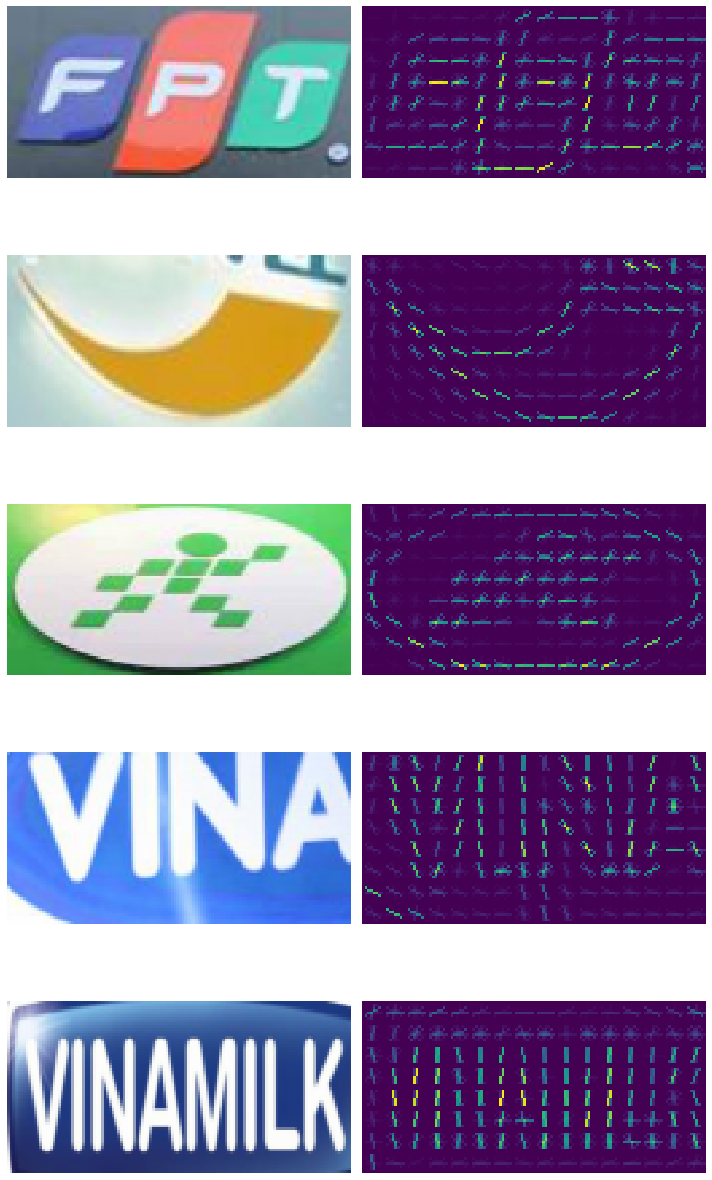

In [12]:
def visualize_some_samples_with_HOG(df, num_samples=5, HOG_ROWS=64, HOG_COLS=128):
    num_samples = min(len(df), num_samples) # in case data frame has less sample than num_samples
    sample_idxs = np.random.choice(len(df), num_samples, replace=False)
    
    figure, axes = plt.subplots(num_samples, 2, figsize=(10,18))
    
    loader = LoadImage(IMG_DIR)
    img_sr = loader.fit_transform(df)
    for i, img in enumerate(img_sr.iloc[sample_idxs]):
        
        img = resize(img, (HOG_ROWS, HOG_COLS))
        
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        
        _, img_hog = hog(image=img, visualize=True)
        
        axes[i, 1].imshow(img_hog)
        axes[i, 1].axis('off')
        
    figure.tight_layout()
    plt.show()

visualize_some_samples_with_HOG(train_df, num_samples=5, HOG_ROWS=64, HOG_COLS=128)

# Xây dựng mô hình phân lớp áp dụng Machine Learning

Mô tả chung về workflow:
- <u>Giai đoạn 1</u>: Tiền xử lý dữ liệu - P1: Load ảnh từ tên file chứa trong DataFrame vào bộ nhớ
  - Input: dataframe gồm 2 cột là `['File name', 'Company']`
  - Output: Series chứa ảnh (mỗi ảnh là một `numpy.ndarray`)
- <u>Giai đoạn 2</u>: Tiền xử lý dữ liệu - P2: Rút trích đặc trưng HOG
  - Input: Series các ảnh
  - Output: `numpy.ndarray` 2D kích thước $M \times N$, trong đó:
    - Mỗi dòng của Output là đặc trưng HOG được rút trích ở ảnh ở dòng tương ứng ở Input
    - Số lượng cột tùy thuộc vào 2 siêu tham số `HOG_ROWS` và `HOG_COLS`, nhưng sẽ giống nhau ở mỗi ảnh, tức là dù ảnh có kích thước khác nhau nhưng số chiều của vector đặc trưng là như nhau
- <u>Giai đoạn 3</u>: Tiền xử lý dữ liệu - P3: Normalize đặc trưng - StandardScaler
  - Input: `numpy.ndarray` 2D kích thước $M \times N$ với $M$ là số lượng ảnh và $N$ là kích thước của vector đặc trưng
  - Output: `numpy.ndarray` 2D kích thước $M \times N$ với các giá trị được chuẩn hóa về cùng khoảng giá trị
  - **Lưu ý**: Nhóm không xử lý giá trị thiếu, do mỗi dòng của dataframe tương ứng với 1 ảnh, thiếu giá trị tức là thiếu hẳn 1 bức ảnh. Nhưng nếu đã có ảnh tức là sẽ rút đặc trưng được và thuật toán HOG đảm bảo sẽ rút được đặc trưng và đặc trưng này đảm bảo không có giá trị thiếu.
- <u>Giai đoạn 4</u>: Huấn luyện mô hình
  - Input: `numpy.ndarray` 2D kích thước $M \times N$
  - Output: `numpy.ndarray` 1D kích thước $M \times 1$ là $M$ lớp tương ứng với $M$ đặc trưng
  
Toàn bộ workflow được thể hiện qua pipeline `full_pipeline`

In [13]:
full_pipeline = Pipeline([
    ('load_image', LoadImage()),
    ('extract_feature', HOGFeatureExtractor()),
    ('normalize', StandardScaler()),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), solver='lbfgs', random_state=RANDOM_SEED))
])

Chạy thử trên tập huấn luyện

In [14]:
def get_raw_X_Y(df: pd.DataFrame):
        return df[['filename']], df['company']

In [15]:
def run(pipeline: Pipeline, df: pd.DataFrame, hyper_params_dict: dict = None, is_train=True):    
    raw_X, raw_Y = get_raw_X_Y(df)
    if hyper_params_dict is not None:
        pipeline.set_params(hyper_params_dict)
    
    if is_train:
        pipeline.fit(X=raw_X, y=raw_Y)
        
    predict = pipeline.predict(X=raw_X)
    
    accuracy = accuracy_score(raw_Y, predict)*100
    return accuracy

In [16]:
accuracy = run(full_pipeline, train_df, None, True) # use default hyper params
print(accuracy)

100.0


Chạy thử trên tập validation

In [17]:
accuracy = run(full_pipeline, val_df, None, False) # use default hyper params
print(accuracy)

95.23809523809523


# Tối ưu tham số mô hình

Ở đây, nhóm sử dụng `GridSearchCV` của thư viện `sklearn` để thực hiện thử và sai để tìm các siêu tham số phù hợp nhất. Về cơ bản, `GridSearchCV` cũng thử lần lượt các siêu tham số như for-loop, nhưng có thêm tham số `n_jobs` giúp chạy song song, giúp giảm thời gian tìm kiếm. Lý do là vì nhóm làm trên ảnh, thời gian rút trích đặc trưng HOG khá lâu. Ngoài ra, khi đưa `LoadImage` vào pipeline, điều này đồng nghĩa với việc ảnh sẽ được load từ ổ đĩa mỗi lần `fit` hay `transform` mặc dù không cần thiết. Nhưng để đảm bảo tính thống nhất từ đầu đến cuối, nhóm vẫn giữ LoadImage trong pipeline

`CV` trong `GridSearchCV` nghĩa là CrossValidation, ở đây, nhóm không sử dụng cross validation mà dùng tập validation chia sẵn. Do đó, đối với bộ dữ liệu đã chia sẵn tập train, validation, sử dụng [PredefinedSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.PredefinedSplit.html) để tạo mask đánh dấu những row thuộc tập train và những row thuộc tập test trên dataframe tổng của hai tập này

Test thử `GridSearchCV` và `PredefinedSplit` với số lượng siêu tham số cần thử nghiệm nhỏ, cụ thể là thử 2 lần với `alpha=0` và `alpha=0.1`:

In [18]:
small_param_grid = {
    'extract_feature__hog_rows': [64],
    'extract_feature__hog_cols': [128],
    'extract_feature__orientations': [9],
    'classifier__alpha': [0, 0.1],
    'classifier__learning_rate_init': [0.01],
}

In [19]:
def search_params(pipeline, train_df, val_df, param_grid, n_jobs=2, verbose_level=1):
    from sklearn.model_selection import PredefinedSplit
    train_val_mask = [-1] * len(train_df) + [0] * len(val_df) # mask value = -1 for train, = 0 for test/validation
    ps = PredefinedSplit(train_val_mask)
    
    grid_search = GridSearchCV(
        pipeline, 
        param_grid,
        n_jobs=n_jobs,
        cv=ps,
        verbose=verbose_level,
        refit=True # automatically fit the pipeline to the whole dataframe with best_params_ after search
    )
    
    combined_df = train_df.append(val_df)
    raw_X, raw_Y = get_raw_X_Y(combined_df)
    grid_search.fit(raw_X, raw_Y)
    
    return grid_search

In [20]:
results = search_params(full_pipeline, train_df, val_df, small_param_grid, n_jobs=2, verbose_level=3)

Fitting 1 folds for each of 2 candidates, totalling 2 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   11.1s finished


In [21]:
print(f'Best score (in range [0..1]): {results.best_score_}')

Best score (in range [0..1]): 0.9841269841269841


In [22]:
print('Best params')
results.best_params_

Best params


{'classifier__alpha': 0.1,
 'classifier__learning_rate_init': 0.01,
 'extract_feature__hog_cols': 128,
 'extract_feature__hog_rows': 64,
 'extract_feature__orientations': 9}

Ngoài ra, mình cũng có thể xem kết quả của tất cả các lần thử bằng `results.cv_results_`, kết quả thống kê được lưu thành một `np.array` có số phần tử bằng số lần thử (ví dụ trên là 2 lần)

In [23]:
results.cv_results_

{'mean_fit_time': array([4.01275134, 8.99753594]),
 'std_fit_time': array([0., 0.]),
 'mean_score_time': array([1.13920069, 0.58895755]),
 'std_score_time': array([0., 0.]),
 'param_classifier__alpha': masked_array(data=[0, 0.1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__learning_rate_init': masked_array(data=[0.01, 0.01],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_extract_feature__hog_cols': masked_array(data=[128, 128],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_extract_feature__hog_rows': masked_array(data=[64, 64],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_extract_feature__orientations': masked_array(data=[9, 9],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier__alpha': 0,
   'classifier__learning_rate

Hoặc xem dưới dạng DataFrame

In [24]:
pd.DataFrame(results.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__alpha,param_classifier__learning_rate_init,param_extract_feature__hog_cols,param_extract_feature__hog_rows,param_extract_feature__orientations,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,4.012751,0.0,1.139201,0.0,0,0.01,128,64,9,"{'classifier__alpha': 0, 'classifier__learning...",0.952381,0.952381,0.0,2
1,8.997536,0.0,0.588958,0.0,0.1,0.01,128,64,9,"{'classifier__alpha': 0.1, 'classifier__learni...",0.984127,0.984127,0.0,1


Sau khi biết rằng mọi thứ đã chạy ổn, giờ nhóm sẽ thử với toàn bộ siêu tham số quan tâm. Bước này chạy **rất lâu**. Hãy kiên nhẫn!

In [25]:
large_param_grid = {
    'extract_feature__hog_rows': [32, 64, 96],             # thử thay đổi kích thước HOG
    'extract_feature__hog_cols': [64, 128, 192],           # thử thay đổi kích thước HOG
    'extract_feature__orientations': [7, 9, 11],           # thử thay đổi số lượng bins
    'classifier__alpha': [0, 0.1, 10],                     # thử thay đổi tham số weight_decay
    'classifier__learning_rate_init': [0.1, 0.01, 10],     # thử thay đổi hệ số học
}

In [ ]:
large_results = search_params(full_pipeline, 
                              train_df, val_df, 
                              large_param_grid, 
                              n_jobs=-1, # use all processors
                              verbose_level=5)

Fitting 1 folds for each of 243 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.1min


# Test